In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dropout, BatchNormalization, MaxPooling2D, GlobalMaxPooling2D, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from keras.utils import plot_model

import os
import random
import warnings
warnings.filterwarnings("ignore")

# Transfer Learning - VGG16

In [2]:
def make_directory(dir_path):
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

In [3]:
import zipfile, shutil

DATASET_PATH = '../output/dogs-vs-cats'
make_directory(DATASET_PATH)

# extract train data
with zipfile.ZipFile('../input/dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall(DATASET_PATH)

# extract test data
with zipfile.ZipFile('../input/dogs-vs-cats/test1.zip', 'r') as zip_ref:
    zip_ref.extractall(DATASET_PATH)

In [4]:
TRAIN_DATA_PATH = os.path.sep.join([DATASET_PATH, 'train'])
TEST_DATA_PATH = os.path.sep.join([DATASET_PATH, 'test1'])

train_files = os.listdir(TRAIN_DATA_PATH)
test_files = os.listdir(TEST_DATA_PATH)

print(f'Train images: {len(train_files)}')
print(f'Test images: {len(test_files)}')

Train images: 25000
Test images: 12500


In [5]:
# dog - 1, cat - 0
classes = []

for file in train_files:
    name = file.split('.')[0]
    if name == 'dog':
        classes.append('dog')
    else:
        classes.append('cat')

df = pd.DataFrame({'filename': train_files, 'class': classes})
df.head(5)

,filename,class
0,dog.890.jpg,dog
1,dog.1178.jpg,dog
2,dog.7845.jpg,dog
3,dog.4632.jpg,dog
4,cat.3660.jpg,cat


In [6]:
train_df, validation_df = train_test_split(df, test_size = 0.2, random_state = 0)

train_df = train_df.reset_index(drop = True)
validation_df = validation_df.reset_index(drop = True)

train_size = train_df.shape[0]
validation_size = validation_df.shape[0]

In [7]:
img_size = 128
batch_size = 32
epochs = 30

In [8]:
train_gen = ImageDataGenerator(rescale = 1./255,
                               rotation_range = 20,
                               horizontal_flip = True,
                               vertical_flip = True,
                               shear_range = 0.2,
                               zoom_range = 0.2)

validation_gen = ImageDataGenerator(rescale = 1./255)

train_gen_data = train_gen.flow_from_dataframe(train_df,
                                               TRAIN_DATA_PATH,
                                               x_col = 'filename',
                                               y_col = 'class',
                                               class_mode = 'categorical',
                                               target_size = (img_size, img_size),
                                               batch_size = batch_size)

val_gen_data = validation_gen.flow_from_dataframe(validation_df,
                                               TRAIN_DATA_PATH,
                                               x_col = 'filename',
                                               y_col = 'class',
                                               class_mode = 'categorical',
                                               target_size = (img_size, img_size),
                                               batch_size = batch_size)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


# Build Model

## Load VGG16 model
* include_top: 모델 마지막의 fully connected layer 포함 여부 결정
* input_shape: input 이미지 shape

58892288/58889256 [==============================] - 1s 0us/step


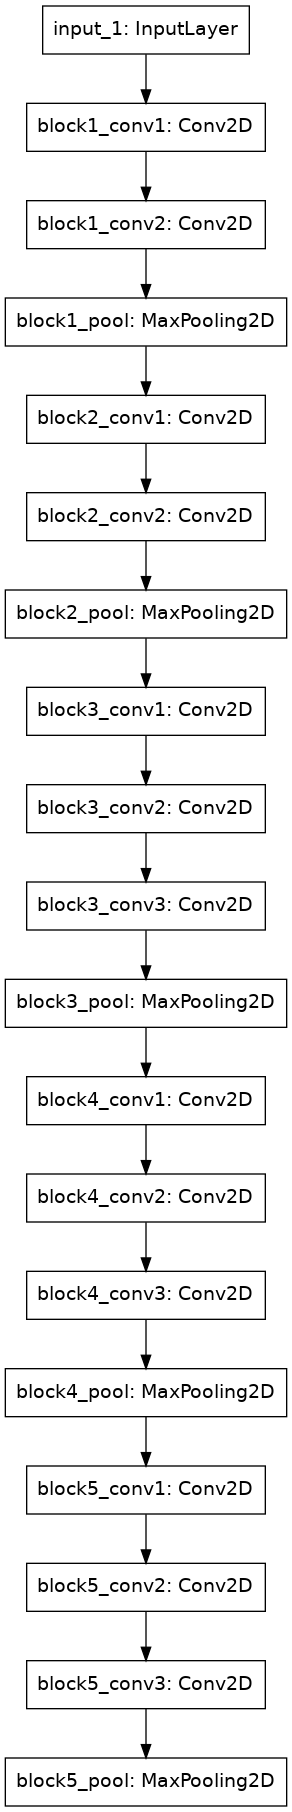

In [9]:
# load vgg16 model
vgg16 = VGG16(weights = 'imagenet', include_top = False, input_shape = (img_size, img_size, 3))
# plot vgg16 structure
plot_model(vgg16)

## 1. Sequential API

In [10]:
# fine-tuning
for layer in vgg16.layers[:15]:
    layer.trainable = False
for layer in vgg16.layers[15:]:
    layer.trainable = True


# sequential API
model = Sequential()
model.add(vgg16)
model.add(GlobalMaxPooling2D())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_max_pooling2d (Global (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 14,846,530
Trainable params: 7,211,266
Non-trainable params: 7,635,264
_________________________________________________________________


In [11]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

In [12]:
# callbacks
es = EarlyStopping(patience = 3)
rp = ReduceLROnPlateau(patience = 3, monitor = 'val_acc', factor = 0.1)

In [13]:
history = model.fit_generator(train_gen_data,
                              validation_data = val_gen_data,
                              epochs = epochs,
                              steps_per_epoch = train_size // batch_size,
                              validation_steps = validation_size // batch_size,
                              callbacks = [es, rp])

Epoch 1/30
625/625 [==============================] - 132s 205ms/step - loss: 1.6489 - accuracy: 0.5824 - val_loss: 0.3006 - val_accuracy: 0.8774
Epoch 2/30
625/625 [==============================] - 128s 205ms/step - loss: 0.4063 - accuracy: 0.8374 - val_loss: 0.2909 - val_accuracy: 0.8732
Epoch 3/30
625/625 [==============================] - 126s 202ms/step - loss: 0.3172 - accuracy: 0.8776 - val_loss: 0.2387 - val_accuracy: 0.9129
Epoch 4/30
625/625 [==============================] - 127s 203ms/step - loss: 0.2925 - accuracy: 0.8892 - val_loss: 0.4661 - val_accuracy: 0.8656
Epoch 5/30
625/625 [==============================] - 126s 201ms/step - loss: 0.3085 - accuracy: 0.8863 - val_loss: 0.1808 - val_accuracy: 0.9233
Epoch 6/30
625/625 [==============================] - 127s 202ms/step - loss: 0.2687 - accuracy: 0.9003 - val_loss: 0.1976 - val_accuracy: 0.9273
Epoch 7/30
625/625 [==============================] - 126s 202ms/step - loss: 0.2435 - accuracy: 0.9064 - val_loss: 0.1851 -

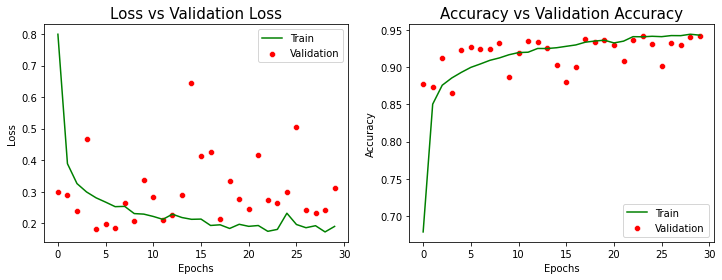

In [21]:
final_epochs = history.epoch
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
sns.lineplot(final_epochs, history.history['loss'], color = 'green', label = 'Train')
sns.scatterplot(final_epochs, history.history['val_loss'], color = 'red', label = 'Validation')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.title('Loss vs Validation Loss', fontsize = 15)

plt.subplot(1, 2, 2)
sns.lineplot(final_epochs, history.history['accuracy'], color = 'green', label = 'Train')
sns.scatterplot(final_epochs, history.history['val_accuracy'], color = 'red', label = 'Validation')
plt.title('Accuracy vs Validation Accuracy', fontsize = 15)
plt.xlabel('Epochs'); plt.ylabel('Accuracy')

plt.show()

In [22]:
loss, accuracy = model.evaluate_generator(val_gen_data, validation_size//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.942107  ;  loss = 0.311475 


## 2. Functional API

In [37]:
train_gen_data.reset()
val_gen_data.reset()

for layer in vgg16.layers[:15]:
    layer.trainable = False
for layer in vgg16.layers[15:]:
    layer.trainable = True
    
# fine tuning 한 layer 따로 뽑아서 output 산출    
output_layer = vgg16.get_layer('block5_pool')
output = output_layer.output

x = GlobalMaxPooling2D()(output)
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(2, activation = 'softmax')(x)

# functional API model 
model2 = Model(vgg16.input, x)

model2.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

In [38]:
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [29]:
history2 = model2.fit_generator(train_gen_data,
                              validation_data = val_gen_data,
                              epochs = epochs,
                              steps_per_epoch = train_size // batch_size,
                              validation_steps = validation_size // batch_size,
                              callbacks = [es, rp])

Epoch 1/30
625/625 [==============================] - 130s 207ms/step - loss: 0.9203 - accuracy: 0.8996 - val_loss: 0.3349 - val_accuracy: 0.9163
Epoch 2/30
625/625 [==============================] - 128s 206ms/step - loss: 0.2417 - accuracy: 0.9261 - val_loss: 0.6358 - val_accuracy: 0.8980
Epoch 3/30
625/625 [==============================] - 128s 204ms/step - loss: 0.2016 - accuracy: 0.9405 - val_loss: 0.5446 - val_accuracy: 0.9014
Epoch 4/30
625/625 [==============================] - 128s 206ms/step - loss: 0.2260 - accuracy: 0.9394 - val_loss: 0.2513 - val_accuracy: 0.9371
Epoch 5/30
625/625 [==============================] - 128s 205ms/step - loss: 0.1950 - accuracy: 0.9429 - val_loss: 0.4224 - val_accuracy: 0.9277
Epoch 6/30
625/625 [==============================] - 128s 205ms/step - loss: 0.2080 - accuracy: 0.9416 - val_loss: 0.2230 - val_accuracy: 0.9391
Epoch 7/30
625/625 [==============================] - 129s 206ms/step - loss: 0.1949 - accuracy: 0.9416 - val_loss: 0.2229 -

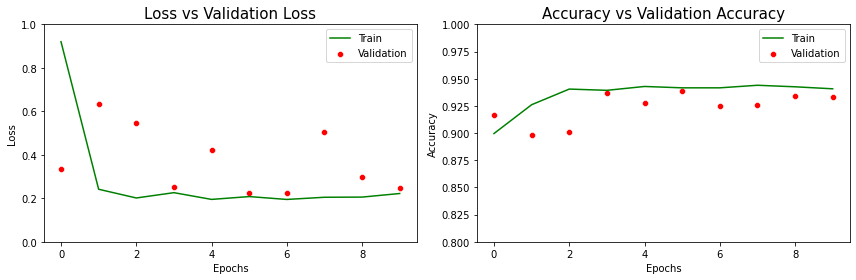

In [34]:
final_epochs = history2.epoch
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
sns.lineplot(final_epochs, history2.history['loss'], color = 'green', label = 'Train')
sns.scatterplot(final_epochs, history2.history['val_loss'], color = 'red', label = 'Validation')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.ylim([0, 1])
plt.title('Loss vs Validation Loss', fontsize = 15)

plt.subplot(1, 2, 2)
sns.lineplot(final_epochs, history2.history['accuracy'], color = 'green', label = 'Train')
sns.scatterplot(final_epochs, history2.history['val_accuracy'], color = 'red', label = 'Validation')
plt.title('Accuracy vs Validation Accuracy', fontsize = 15); plt.ylim([0.8, 1])
plt.xlabel('Epochs'); plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [36]:
loss, accuracy = model2.evaluate_generator(val_gen_data, validation_size //batch_size, workers = 12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.932893  ;  loss = 0.246654 
